In [ ]:
# Data loading
import os
import numpy as np

HCP_folder = '/mounts/GRG'

In [ ]:
import numpy as np
from dipy.viz import regtools
from distutils.version import LooseVersion
from dipy.utils.optpkg import optional_package

tf, have_tf, _ = optional_package('tensorflow')
layers, _, _ = optional_package("tensorflow.keras.layers")
matplotlib, has_mpl, setup_module = optional_package("matplotlib")
plt, _, _ = optional_package("matplotlib.pyplot")

import tensorflow.keras.backend as K

if have_tf:
    if LooseVersion(tf.__version__) < LooseVersion('2.0.0'):
        raise ImportError('Please upgrade to TensorFlow 2+')

print(tf.__version__)
print(tf.keras.backend.image_data_format())

2.2.0
channels_last


In [ ]:
# def ncc(y_true, y_pred):
#     eps = tf.constant(1e-7, 'float32')
#     ndim = len(tf.keras.backend.int_shape(y_true))

#     y_true_mean = tf.reduce_mean(y_true, axis=range(1, ndim-1),
#                                   keepdims=True)
#     y_pred_mean = tf.reduce_mean(y_pred, axis=range(1, ndim-1),
#                                   keepdims=True)

#     y_true_std = tf.math.reduce_std(y_true, axis=range(1, ndim-1),
#                                     keepdims=True)
#     y_pred_std = tf.math.reduce_std(y_pred, axis=range(1, ndim-1),
#                                     keepdims=True)

#     y_true_hat = (y_true - y_true_mean) / (y_true_std + eps)
#     y_pred_hat = (y_pred - y_pred_mean) / (y_pred_std + eps)

#     return -tf.reduce_mean(y_true_hat * y_pred_hat)


In [ ]:
def mutualInformation(bin_centers,
                      sigma_ratio=0.5,    # sigma for soft MI. If not provided, it will be half of a bin length
                      max_clip=1,
                      crop_background=False, # crop_background should never be true if local_mi is True
                      local_mi=False,
                      patch_size=1):
    """
    mutual information for image-image pairs.
    Author: Courtney Guo. See thesis https://dspace.mit.edu/handle/1721.1/123142
    """
    # print("vxm:mutual information loss is experimental.", file=sts.stderr)

    if local_mi:
        return localMutualInformation(bin_centers, vol_size=(128, 128, 128), sigma_ratio=sigma_ratio, max_clip=max_clip, patch_size=patch_size)

    else:
        return globalMutualInformation(bin_centers, sigma_ratio, max_clip, crop_background)


def localMutualInformation(bin_centers,
                      vol_size=(128, 128, 128),
                      sigma_ratio=0.5,
                      max_clip=1,
                      patch_size=1):
    """
    Local Mutual Information for image-image pairs
    # vol_size is something like (160, 192, 224)
    This function assumes that y_true and y_pred are both (batch_sizexheightxwidthxdepthxchan)
    Author: Courtney Guo. See thesis at https://dspace.mit.edu/handle/1721.1/123142
    """
    # print("vxm:mutual information loss is experimental.", file=sts.stderr)

    """ prepare MI. """
    vol_bin_centers = K.variable(bin_centers)
    num_bins = len(bin_centers)
    sigma = np.mean(np.diff(bin_centers))*sigma_ratio

    preterm = K.variable(1 / (2 * np.square(sigma)))

    def local_mi(y_true, y_pred):
        y_pred = K.clip(y_pred, 0, max_clip)
        y_true = K.clip(y_true, 0, max_clip)

        # reshape bin centers to be (1, 1, B)
        o = [1, 1, 1, 1, num_bins]
        vbc = K.reshape(vol_bin_centers, o)

        # compute padding sizes
        x, y, z = vol_size
        x_r = -x % patch_size
        y_r = -y % patch_size
        z_r = -z % patch_size
        pad_dims = [[0,0]]
        pad_dims.append([x_r//2, x_r - x_r//2])
        pad_dims.append([y_r//2, y_r - y_r//2])
        pad_dims.append([z_r//2, z_r - z_r//2])
        pad_dims.append([0,0])
        padding = tf.constant(pad_dims)

        # compute image terms
        # num channels of y_true and y_pred must be 1
        I_a = K.exp(- preterm * K.square(tf.pad(y_true, padding, 'CONSTANT')  - vbc))
        I_a /= K.sum(I_a, -1, keepdims=True)

        I_b = K.exp(- preterm * K.square(tf.pad(y_pred, padding, 'CONSTANT')  - vbc))
        I_b /= K.sum(I_b, -1, keepdims=True)

        I_a_patch = tf.reshape(I_a, [(x+x_r)//patch_size, patch_size, (y+y_r)//patch_size, patch_size, (z+z_r)//patch_size, patch_size, num_bins])
        I_a_patch = tf.transpose(I_a_patch, [0, 2, 4, 1, 3, 5, 6])
        I_a_patch = tf.reshape(I_a_patch, [-1, patch_size**3, num_bins])

        I_b_patch = tf.reshape(I_b, [(x+x_r)//patch_size, patch_size, (y+y_r)//patch_size, patch_size, (z+z_r)//patch_size, patch_size, num_bins])
        I_b_patch = tf.transpose(I_b_patch, [0, 2, 4, 1, 3, 5, 6])
        I_b_patch = tf.reshape(I_b_patch, [-1, patch_size**3, num_bins])

        # compute probabilities
        I_a_permute = K.permute_dimensions(I_a_patch, (0,2,1))
        pab = K.batch_dot(I_a_permute, I_b_patch)  # should be the right size now, nb_labels x nb_bins
        pab /= patch_size**3
        pa = tf.reduce_mean(I_a_patch, 1, keepdims=True)
        pb = tf.reduce_mean(I_b_patch, 1, keepdims=True)

        papb = K.batch_dot(K.permute_dimensions(pa, (0,2,1)), pb) + K.epsilon()
        mi = K.mean(K.sum(K.sum(pab * K.log(pab/papb + K.epsilon()), 1), 1))

        return mi

    def loss(y_true, y_pred):
        return -local_mi(y_true, y_pred)

    return loss

def globalMutualInformation(bin_centers,
                      sigma_ratio=0.5,
                      max_clip=1,
                      crop_background=False):
    """
    Mutual Information for image-image pairs
    Building from neuron.losses.MutualInformationSegmentation()
    This function assumes that y_true and y_pred are both (batch_size x height x width x depth x nb_chanels)
    Author: Courtney Guo. See thesis at https://dspace.mit.edu/handle/1721.1/123142
    """
    # print("vxm:mutual information loss is experimental.", file=sts.stderr)

    """ prepare MI. """
    vol_bin_centers = K.variable(bin_centers)
    num_bins = len(bin_centers)
    sigma = np.mean(np.diff(bin_centers))*sigma_ratio

    preterm = K.variable(1 / (2 * np.square(sigma)))

    def mi(y_true, y_pred):
        """ soft mutual info """
        y_pred = K.clip(y_pred, 0, max_clip)
        y_true = K.clip(y_true, 0, max_clip)

        if crop_background:
            # does not support variable batch size
            thresh = 0.0001
            padding_size = 20
            filt = tf.ones([padding_size, padding_size, padding_size, 1, 1])

            smooth = tf.nn.conv3d(y_true, filt, [1, 1, 1, 1, 1], "SAME")
            mask = smooth > thresh
            # mask = K.any(K.stack([y_true > thresh, y_pred > thresh], axis=0), axis=0)
            y_pred = tf.boolean_mask(y_pred, mask)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = K.expand_dims(K.expand_dims(y_pred, 0), 2)
            y_true = K.expand_dims(K.expand_dims(y_true, 0), 2)

        else:
            # reshape: flatten images into shape (batch_size, heightxwidthxdepthxchan, 1)
            y_true = K.reshape(y_true, (-1, K.prod(K.shape(y_true)[1:])))
            y_true = K.expand_dims(y_true, 2)
            y_pred = K.reshape(y_pred, (-1, K.prod(K.shape(y_pred)[1:])))
            y_pred = K.expand_dims(y_pred, 2)

        nb_voxels = tf.cast(K.shape(y_pred)[1], tf.float32)

        # reshape bin centers to be (1, 1, B)
        o = [1, 1, np.prod(vol_bin_centers.get_shape().as_list())]
        vbc = K.reshape(vol_bin_centers, o)

        # compute image terms
        I_a = K.exp(- preterm * K.square(y_true  - vbc))
        I_a /= K.sum(I_a, -1, keepdims=True)

        I_b = K.exp(- preterm * K.square(y_pred  - vbc))
        I_b /= K.sum(I_b, -1, keepdims=True)

        # compute probabilities
        I_a_permute = K.permute_dimensions(I_a, (0,2,1))
        pab = K.batch_dot(I_a_permute, I_b)  # should be the right size now, nb_labels x nb_bins
        pab /= nb_voxels
        pa = tf.reduce_mean(I_a, 1, keepdims=True)
        pb = tf.reduce_mean(I_b, 1, keepdims=True)

        papb = K.batch_dot(K.permute_dimensions(pa, (0,2,1)), pb) + K.epsilon()
        mi = K.sum(K.sum(pab * K.log(pab/papb + K.epsilon()), 1), 1)

        return mi

    def loss(y_true, y_pred):
        return -mi(y_true, y_pred)

    return loss


New NCC loss

In [ ]:
# def ncc_new(s, m, window=(9, 9, 9)):
#     eps = tf.constant(1e-7, 'float32')

#     s2 = s*s
#     m2 = m*m
#     sm = s*m

#     filters = tf.ones([*window, 1, 1])
#     strides = [1]*5

#     s_sum = tf.nn.conv3d(s, filters, strides=strides, padding='SAME')
#     m_sum = tf.nn.conv3d(m, filters, strides=strides, padding='SAME')
#     s2_sum = tf.nn.conv3d(s2, filters, strides=strides, padding='SAME')
#     m2_sum = tf.nn.conv3d(m2, filters, strides=strides, padding='SAME')
#     sm_sum = tf.nn.conv3d(sm, filters, strides=strides, padding='SAME')

#     window_size = np.prod(window)
#     s_mean = s_sum/window_size
#     m_mean = m_sum/window_size

#     cross = sm_sum - m_mean*s_sum - s_mean*m_sum + s_mean*m_mean*window_size
#     s_var = s2_sum - 2*s_mean*s_sum + s_mean*s_mean*window_size
#     m_var = m2_sum - 2*m_mean*m_sum + m_mean*m_mean*window_size

#     cc = cross * cross/(s_var * m_var + eps)
#     return -tf.reduce_mean(cc)

Regualrization loss

In [ ]:
def gradient_loss(phi, norm=2):
    di = tf.abs(phi[:, 1:, :, :, :] - phi[:, :-1, :, :, :])
    dj = tf.abs(phi[:, :, 1:, :, :] - phi[:, :, :-1, :, :])
    dk = tf.abs(phi[:, :, :, 1:, :] - phi[:, :, :, :-1, :])

    loss = tf.reduce_mean(di) + tf.reduce_mean(dj) + tf.reduce_mean(dk)
    if norm == 2:
        loss = tf.reduce_mean(di**2) + tf.reduce_mean(dj**2) + tf.reduce_mean(dk**2)
    return loss

In [ ]:
def regular_grid_3d(depth, height, width):
    i = tf.linspace(-1.0, 1.0, depth)
    j = tf.linspace(-1.0, 1.0, height)
    k = tf.linspace(-1.0, 1.0, width)

    I, J, K = tf.meshgrid(i, j, k, indexing='ij')

    grid = tf.stack([I, J, K], axis=-1)
    return grid

In [ ]:
def grid_sample_3d(moving, grid):
    nb, nd, nh, nw, nc = tf.shape(moving)

    i = grid[..., 0]  # shape (N, D, H, W)
    j = grid[..., 1]
    k = grid[..., 2]
    i = tf.cast(i, 'float32')
    j = tf.cast(j, 'float32')
    k = tf.cast(k, 'float32')

    # Scale i, j and k from [-1.0, 1.0] to [0, D], [0, H] and [0, W] respectively.
    i = (i + 1.0) * 0.5 * tf.cast(nd-1, 'float32')
    j = (j + 1.0) * 0.5 * tf.cast(nh-1, 'float32')
    k = (k + 1.0) * 0.5 * tf.cast(nw-1, 'float32')

    i_max = tf.cast(nd - 1, 'int32')
    j_max = tf.cast(nh - 1, 'int32')
    k_max = tf.cast(nw - 1, 'int32')
    zero = tf.constant(0, 'int32')

    # The value at (i, j, k) is a weighted average of the values at the
    # eight nearest integer locations: (i0, j0, k0), (i0, j0, k1), (i0, j1, k0),
    # (i0, j1, k1), (i1, j0, k0), (i1, j0, k1), (i1, j1, k0) and (i1, j1, k1)
    # where i0 = floor(i), i1 = ceil(i).
    i0 = tf.cast(tf.floor(i), 'int32')
    i1 = i0 + 1
    j0 = tf.cast(tf.floor(j), 'int32')
    j1 = j0 + 1
    k0 = tf.cast(tf.floor(k), 'int32')
    k1 = k0 + 1

    # Make sure indices are within the boundaries of the image.
    i0 = tf.clip_by_value(i0, zero, i_max)
    i1 = tf.clip_by_value(i1, zero, i_max)
    j0 = tf.clip_by_value(j0, zero, j_max)
    j1 = tf.clip_by_value(j1, zero, j_max)
    k0 = tf.clip_by_value(k0, zero, k_max)
    k1 = tf.clip_by_value(k1, zero, k_max)

    # Collect indices of the four corners.
    b = tf.ones_like(i0) * tf.reshape(tf.range(nb), [nb, 1, 1, 1])
    idx_a = tf.stack([b, i1, j0, k0], axis=-1)  # all front-top-left corners
    idx_b = tf.stack([b, i1, j1, k0], axis=-1)  # all front-bottom-left corners
    idx_c = tf.stack([b, i1, j0, k1], axis=-1)  # all front-top-right corners
    idx_d = tf.stack([b, i1, j1, k1], axis=-1)  # all front-bottom-right corners
    idx_e = tf.stack([b, i0, j0, k0], axis=-1)  # all back-top-left corners
    idx_f = tf.stack([b, i0, j1, k0], axis=-1)  # all back-bottom-left corners
    idx_g = tf.stack([b, i0, j0, k1], axis=-1)  # all back-top-right corners
    idx_h = tf.stack([b, i0, j1, k1], axis=-1)  # all back-bottom-right corners
    # shape (N, D, H, W, 3)

    # Collect values at the corners.
    moving_a = tf.gather_nd(moving, idx_a)  # all front-top-left values
    moving_b = tf.gather_nd(moving, idx_b)  # all front-bottom-left values
    moving_c = tf.gather_nd(moving, idx_c)  # all front-top-right values
    moving_d = tf.gather_nd(moving, idx_d)  # all front-bottom-right values
    moving_e = tf.gather_nd(moving, idx_e)  # all back-top-left values
    moving_f = tf.gather_nd(moving, idx_f)  # all back-bottom-left values
    moving_g = tf.gather_nd(moving, idx_g)  # all back-top-right values
    moving_h = tf.gather_nd(moving, idx_h)  # all back-bottom-right values
    # shape (N, D, H, W, C)

    i0_f = tf.cast(i0, 'float32')
    i1_f = tf.cast(i1, 'float32')
    j0_f = tf.cast(j0, 'float32')
    j1_f = tf.cast(j1, 'float32')
    k0_f = tf.cast(k0, 'float32')
    k1_f = tf.cast(k1, 'float32')

    # Calculate the weights.
    wa = tf.expand_dims((i - i0_f) * (j1_f - j) * (k1_f - k), axis=-1)
    wb = tf.expand_dims((i - i0_f) * (j - j0_f) * (k1_f - k), axis=-1)
    wc = tf.expand_dims((i - i0_f) * (j1_f - j) * (k - k0_f), axis=-1)
    wd = tf.expand_dims((i - i0_f) * (j - j0_f) * (k - k0_f), axis=-1)
    we = tf.expand_dims((i1_f - i) * (j1_f - j) * (k1_f - k), axis=-1)
    wf = tf.expand_dims((i1_f - i) * (j - j0_f) * (k1_f - k), axis=-1)
    wg = tf.expand_dims((i1_f - i) * (j1_f - j) * (k - k0_f), axis=-1)
    wh = tf.expand_dims((i1_f - i) * (j - j0_f) * (k - k0_f), axis=-1)

    # Calculate the weighted sum.
    moved = tf.add_n([wa * moving_a, wb * moving_b, wc * moving_c,
                      wd * moving_d, we * moving_e, wf * moving_f,
                      wg * moving_g, wh * moving_h])
    return moved

In [ ]:
def voxelmorph1(input_shape=(128, 128, 1)):
    in_channels = 1
    out_channels = 3
    input_shape = input_shape + (in_channels,)
    moving = layers.Input(shape=input_shape, name='moving')
    static = layers.Input(shape=input_shape, name='static')
    x_in = layers.concatenate([static, moving], axis=-1)

    # encoder
    x1 = layers.Conv3D(16, kernel_size=3, strides=2, padding='same',
                        kernel_initializer='he_normal')(x_in)
    x1 = layers.LeakyReLU(alpha=0.2)(x1)  # 16

    x2 = layers.Conv3D(32, kernel_size=3, strides=2, padding='same',
                        kernel_initializer='he_normal')(x1)
    x2 = layers.LeakyReLU(alpha=0.2)(x2)  # 8

    x3 = layers.Conv3D(32, kernel_size=3, strides=2, padding='same',
                        kernel_initializer='he_normal')(x2)
    x3 = layers.LeakyReLU(alpha=0.2)(x3)  # 4

    x4 = layers.Conv3D(32, kernel_size=3, strides=2, padding='same',
                        kernel_initializer='he_normal')(x3)
    x4 = layers.LeakyReLU(alpha=0.2)(x4)  # 2

    # decoder [32, 32, 32, 32, 8, 8]
    x = layers.Conv3D(32, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(x4)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.UpSampling3D(size=2)(x)  # 4
    x = layers.concatenate([x, x3], axis=-1)  # 4

    x = layers.Conv3D(32, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.UpSampling3D(size=2)(x)  # 8
    x = layers.concatenate([x, x2], axis=-1)  # 8

    x = layers.Conv3D(32, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.UpSampling3D(size=2)(x)  # 16
    x = layers.concatenate([x, x1], axis=-1)  # 16

    x = layers.Conv3D(32, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv3D(8, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)  # 16

    x = layers.UpSampling3D(size=2)(x)  # 32
    x = layers.concatenate([x, x_in], axis=-1)
    x = layers.Conv3D(8, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)  # 32

    kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0,
                                                            stddev=1e-5)
    deformation = layers.Conv3D(out_channels, kernel_size=3, strides=1,
                                padding='same',
                                kernel_initializer=kernel_initializer)(x)

    nb, nd, nh, nw, nc = tf.shape(deformation)

    # Regular grid.
    grid = regular_grid_3d(nd, nh, nw)  # shape (D, H, W, 2)
    grid = tf.expand_dims(grid, axis=0)  # shape (1, D, H, W, 2)
    multiples = tf.stack([nb, 1, 1, 1, 1])
    grid = tf.tile(grid, multiples)

    # Compute the new sampling grid.
    grid_new = grid + deformation
    grid_new = tf.clip_by_value(grid_new, -1, 1)

    # Sample the moving image using the new sampling grid.
    moved = grid_sample_3d(moving, grid_new)

    model = tf.keras.Model(inputs=[static, moving],
                            outputs=[moved, deformation], name='voxelmorph1')
    return model

In [ ]:
@tf.function
def train_step(model, moving, moving2, static, criterion, optimizer):
    nb, nd, nh, nw, nc = tf.keras.backend.int_shape(moving)  # moving.shape

    # Repeat the static image along the batch dim.
    multiples = tf.constant([nb, 1, 1, 1, 1], tf.int32)
    static = tf.tile(static, multiples)

    # Define the GradientTape context for automatic differentiation.
    with tf.GradientTape() as tape:
        # Get the deformation field
        # inputs = tf.concat([moving, static], axis=-1)
        moved, deformation = model({'moving': moving, 'static': static})

        moved2, deformation2 = model({'moving': moving2, 'static': static})

        # Compute the loss.
        # loss = criterion(moved, static)
        loss = 0.5 * criterion(static, moved) + 1 * gradient_loss(deformation) + 0.5 * criterion(static, moved2) + 1 * gradient_loss(deformation2) + 1 * criterion(moved, moved2)

    # Compute gradients.
    grads = tape.gradient(loss, model.trainable_variables)
    # Update the trainable parameters.
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [ ]:
@tf.function
def test_step(model, moving, moving2, static, criterion):
    nb, nd, nh, nw, nc = tf.keras.backend.int_shape(moving)  # moving.shape

    # Repeat the static image along the batch dim.
    multiples = tf.constant([nb, 1, 1, 1, 1], tf.int32)
    static = tf.tile(static, multiples)

    # Get the deformation field.
    # inputs = tf.concat([moving, static], axis=-1)
    moved, deformation = model({'moving': moving, 'static': static}, training=False)
    moved2, deformation2 = model({'moving': moving2, 'static': static}, training=False)

    # Compute the loss.
    # loss = criterion(moved, static)
    loss = 0.5 * criterion(static, moved) + 1 * gradient_loss(deformation) + 0.5 * criterion(static, moved2) + 1 * gradient_loss(deformation2) + 1 * criterion(moved, moved2)
    return loss

In [ ]:
def plot_images(model, moving, moving2, static):
    nb, nd, nh, nw, nc = moving.shape

    # Repeat the static image along the batch dim.
    multiples = tf.constant([nb, 1, 1, 1, 1], tf.int32)
    static = tf.tile(static, multiples)

    moved, deformation = model({'moving': moving, 'static': static}, training=False)
    moved2, deformation2 = model({'moving': moving2, 'static': static}, training=False)

    print(deformation.shape, tf.reduce_max(deformation), tf.reduce_min(deformation), tf.reduce_mean(deformation))
    print(deformation2.shape, tf.reduce_max(deformation2), tf.reduce_min(deformation2), tf.reduce_mean(deformation2))

    deformation = deformation.numpy()
    moved = moved.numpy().squeeze(axis=-1) * 255.0
    # moved = moved.astype(np.uint8)[:,:,nh//2,...]
    moving = moving.numpy().squeeze(axis=-1) * 255.0
    # moving = moving.astype(np.uint8)[:,:,nh//2,...]
    static = static.numpy().squeeze(axis=-1) * 255.0
    # static = static.astype(np.uint8)[:,:,nh//2,...]

    deformation2 = deformation2.numpy()
    moved2 = moved2.numpy().squeeze(axis=-1) * 255.0
    # moved = moved.astype(np.uint8)[:,:,nh//2,...]
    moving2 = moving2.numpy().squeeze(axis=-1) * 255.0
    # moving = moving.astype(np.uint8)[:,:,nh//2,...]

    # # Plot images.
    # fig = plt.figure(figsize=(3 * 1.7, nb * 1.7))
    # titles_list = ['Static', 'Moved', 'Moving']
    # images_list = [static, moved, moving]

    # moved = moving
    for i in range(nb):
        # for j in range(3):
        #     ax = fig.add_subplot(nb, 3, i * 3 + j + 1)
        #     if i == 0:
        #         ax.set_title(titles_list[j], fontsize=20)
        #     ax.set_axis_off()
        #     ax.imshow(images_list[j][i], cmap='gray')
        regtools.overlay_slices(static[i], moved[i], None, 0,
                                "%d Static"%i, "%d Transformed"%i,
                                "%d_0.png" % (i))
        regtools.overlay_slices(static[i], moved[i], None, 1,
                                "%d Static"%i, "%d Transformed"%i,
                                "%d_1.png" % (i))
        regtools.overlay_slices(static[i], moved[i], None, 2,
                                "%d Static"%i, "%d Transformed"%i,
                                "%d_2.png" % (i))

        regtools.overlay_slices(static[i], moved2[i], None, 0,
                                "%d Static"%i, "%d Transformed"%i,
                                "%d_0.png" % (i))
        regtools.overlay_slices(static[i], moved2[i], None, 1,
                                "%d Static"%i, "%d Transformed"%i,
                                "%d_1.png" % (i))
        regtools.overlay_slices(static[i], moved2[i], None, 2,
                                "%d Static"%i, "%d Transformed"%i,
                                "%d_2.png" % (i))
        d = {'static': static[i], 'moved': moved[i], 'moving': moving[i], 'deformation': deformation[i],
             'moved2': moved2[i], 'moving2': moving2[i], 'deformation2': deformation2[i]}
        np.save('drive/My Drive/DIPY/t1_t2/results/sample%d.npy'%(i), d)

    # plt.tight_layout()
    # plt.show()

In [ ]:
def main(args):

    brain = np.load('/content/drive/My Drive/DIPY/t1_t2/t1_t2_affine_128.npy')
    static = np.load('/content/drive/My Drive/DIPY/t1_t2/static_128.npy')
    brain = brain.astype(np.float32)/255.0
    x_train = brain[:75,...][...,None].copy()
    # x_train = x_train.astype(np.float32)/255.0
    x_test = brain[75:,...][...,None].copy()
    # x_test = x_test.astype(np.float32)/255.0
    x_sample = x_test.copy()
    # static = brain[-1,...][None,...,None]
    static = static[None,...,None]
    static = static.astype(np.float32)/255.0



    min_val = min(static.min(), brain.min())
    max_val = max(static.max(), brain.max())
    print(min_val, max_val)
    bin_centers = np.linspace(min_val, max_val, 32)

    del brain


    x_train = tf.convert_to_tensor(x_train, dtype='float32')
    x_test = tf.convert_to_tensor(x_test, dtype='float32')
    x_sample = tf.convert_to_tensor(x_sample, dtype='float32')
    static = tf.convert_to_tensor(static, dtype='float32')
    # print(x_train.shape, x_test.shape, x_sample.shape, static.shape)

    from_tensor_slices = tf.data.Dataset.from_tensor_slices
    x_train = from_tensor_slices(x_train).shuffle(10000).batch(args.batch_size)
    x_test = from_tensor_slices(x_test).shuffle(10000).batch(args.batch_size)

    S = 128
    # Create a model instance.
    model = voxelmorph1(input_shape=(S, S, S))

    # replace
    model.load_weights('drive/My Drive/DIPY/t1_t2/results/checkpoints/59.h5')
    # or
    tf.keras.models.load_model('name of .h5')


    # Select optimizer and loss function.
    optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)
    # criterion = ncc_new
    criterion = mutualInformation(bin_centers, sigma_ratio=0.5, max_clip=1, crop_background=False, local_mi=True, patch_size=12)

    # Define the metrics to track training and testing losses.
    m_train = tf.keras.metrics.Mean(name='loss_train')
    m_test = tf.keras.metrics.Mean(name='loss_test')

    # Train and evaluate the model.
    for epoch in range(args.epochs):
        m_train.reset_states()
        m_test.reset_states()
        for i, moving in enumerate(x_train):
            loss_train = train_step(model, moving, static, criterion,
                                    optimizer)
            m_train.update_state(loss_train)

        for i, moving in enumerate(x_test):
            loss_test = test_step(model, moving, static, criterion)
            m_test.update_state(loss_test)

        model.save_weights('drive/My Drive/DIPY/t1_t2/results/checkpoints/%d_2.h5'%epoch)
        print('Epoch: %3d/%d\tTrain Loss: %.6f\tTest Loss: %.6f'
              % (epoch + 1, args.epochs, m_train.result(), m_test.result()))
    print('\n')

    # Show sample results.
    plot_images(model, x_sample, static)

    # Save the trained model.
    if args.save_model:
        model.save_weights('/content/drive/My Drive/DIPY/t1_t2/results/voxelmorph1-weights.h5')

# Moved vs. Static

0.0 1.0
Epoch:   1/60	Train Loss: -0.068995	Test Loss: -0.068387
Epoch:   2/60	Train Loss: -0.071235	Test Loss: -0.068460
Epoch:   3/60	Train Loss: -0.071573	Test Loss: -0.068205
Epoch:   4/60	Train Loss: -0.071545	Test Loss: -0.068675
Epoch:   5/60	Train Loss: -0.072123	Test Loss: -0.068567
Epoch:   6/60	Train Loss: -0.071477	Test Loss: -0.068373
Epoch:   7/60	Train Loss: -0.071721	Test Loss: -0.068321
Epoch:   8/60	Train Loss: -0.071719	Test Loss: -0.068545
Epoch:   9/60	Train Loss: -0.072055	Test Loss: -0.068779
Epoch:  10/60	Train Loss: -0.072235	Test Loss: -0.067228
Epoch:  11/60	Train Loss: -0.071901	Test Loss: -0.068762
Epoch:  12/60	Train Loss: -0.072225	Test Loss: -0.069084
Epoch:  13/60	Train Loss: -0.072299	Test Loss: -0.068797
Epoch:  14/60	Train Loss: -0.072327	Test Loss: -0.067969
Epoch:  15/60	Train Loss: -0.072252	Test Loss: -0.068939
Epoch:  16/60	Train Loss: -0.072243	Test Loss: -0.068883
Epoch:  17/60	Train Loss: -0.072632	Test Loss: -0.069182
Epoch:  18/60	Train Los

/usr/local/lib/python3.6/dist-packages/dipy/viz/regtools.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, len(imgs))


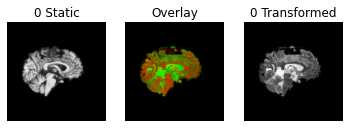

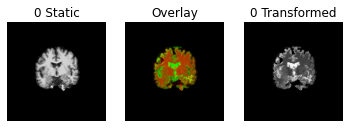

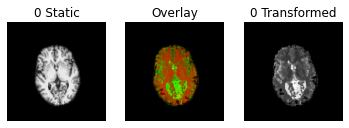

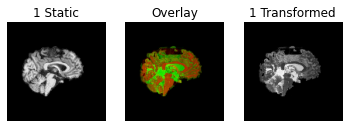

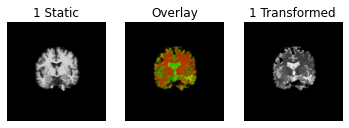

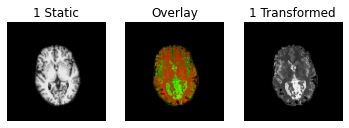

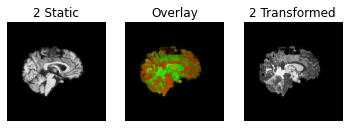

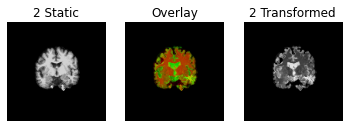

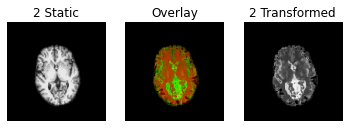

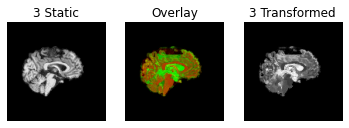

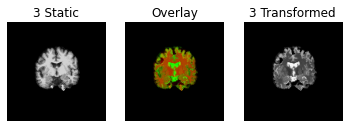

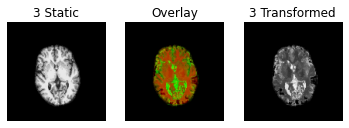

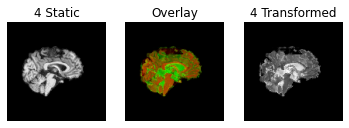

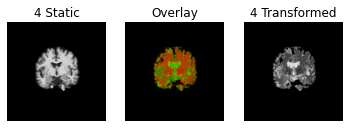

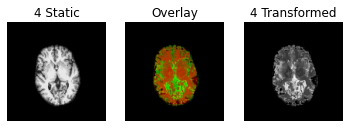

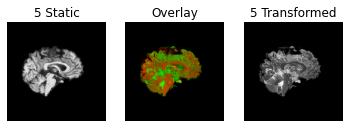

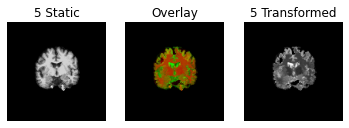

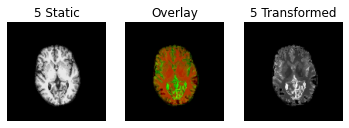

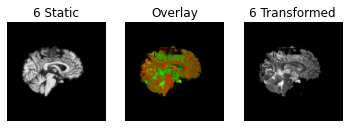

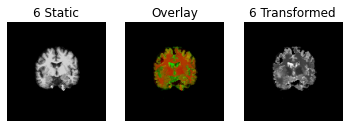

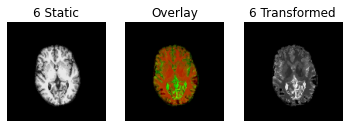

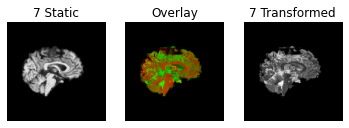

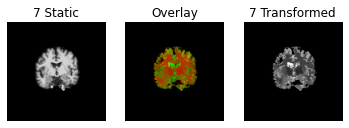

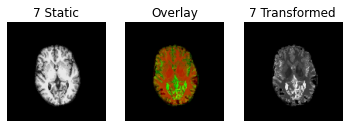

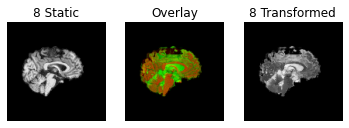

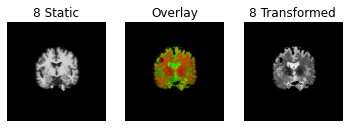

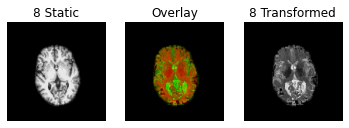

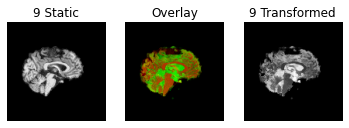

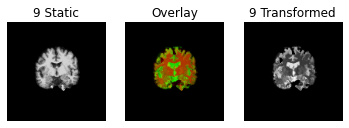

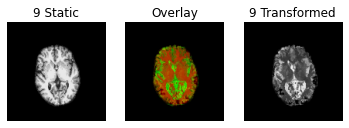

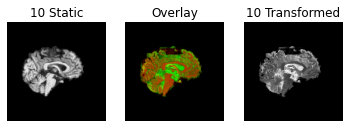

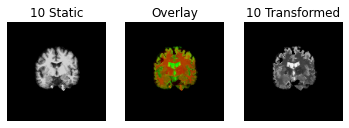

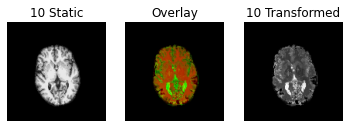

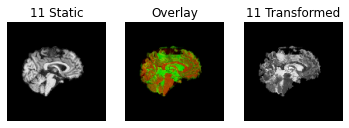

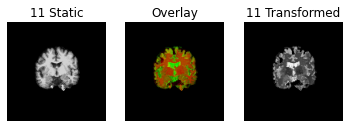

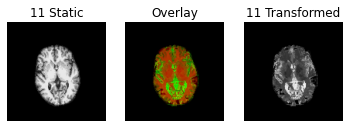

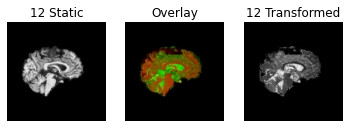

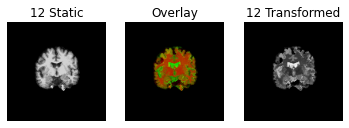

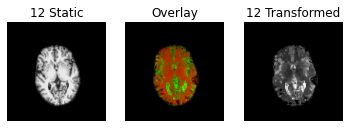

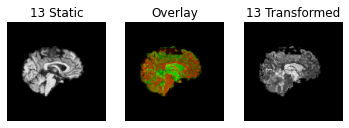

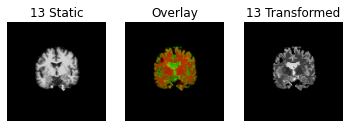

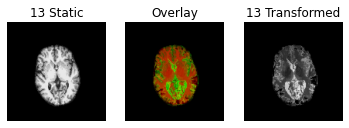

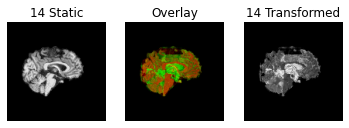

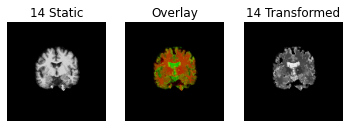

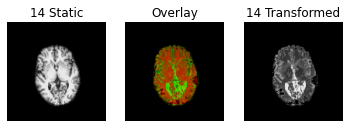

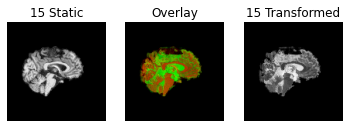

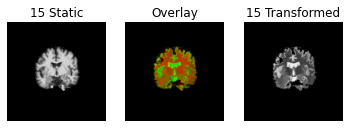

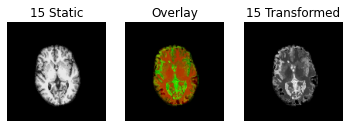

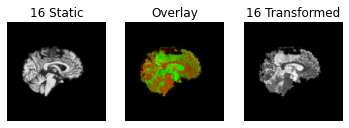

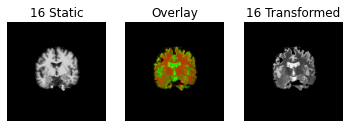

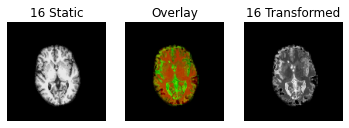

In [ ]:
if __name__ == '__main__':

    class Args():
        batch_size = 1
        epochs = 60
        lr = 0.001
        # label = 1  # which digit images to train on?
        # num_samples = 5  # number of sample results to show
        save_model = True

    args = Args()
    main(args)

# Moving vs. Static

0.0 1.0
(17, 128, 128, 128, 3) tf.Tensor(0.00016610083, shape=(), dtype=float32) tf.Tensor(-0.00017653074, shape=(), dtype=float32) tf.Tensor(2.9772713e-07, shape=(), dtype=float32)


/usr/local/lib/python3.6/dist-packages/dipy/viz/regtools.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, len(imgs))


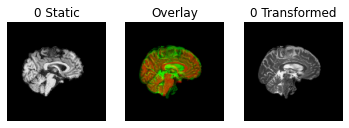

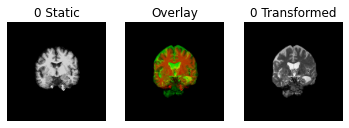

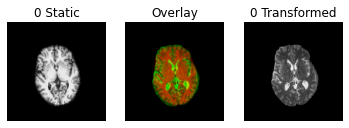

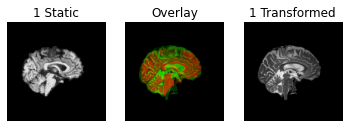

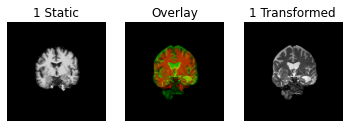

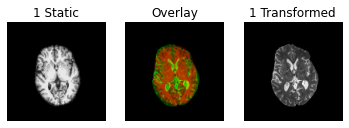

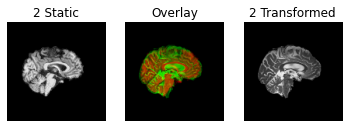

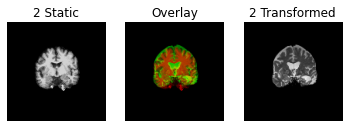

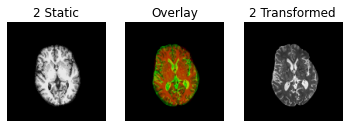

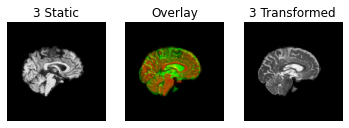

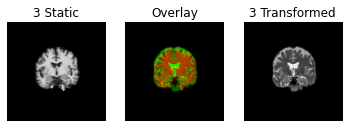

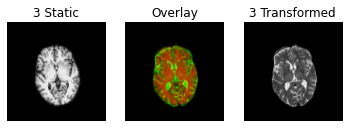

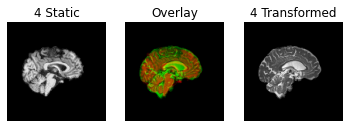

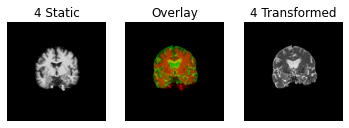

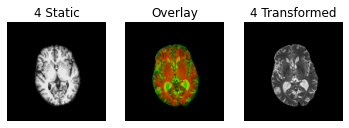

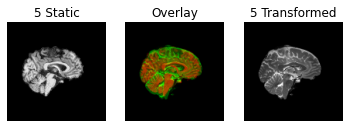

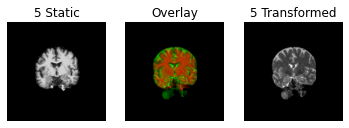

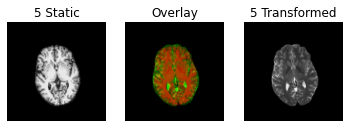

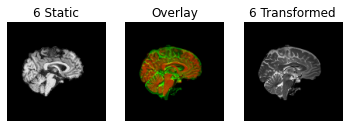

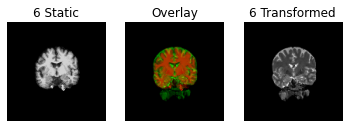

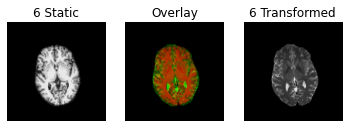

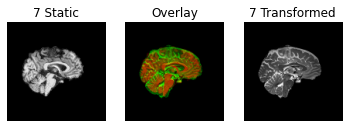

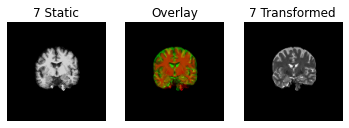

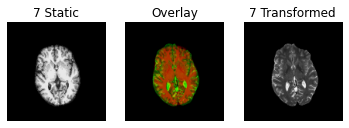

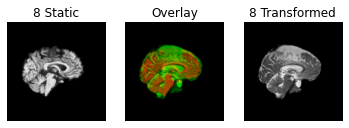

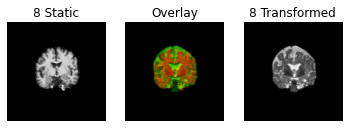

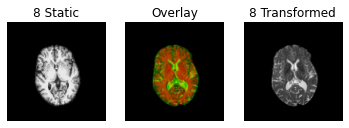

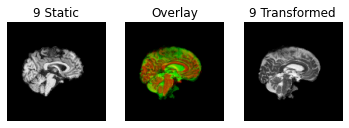

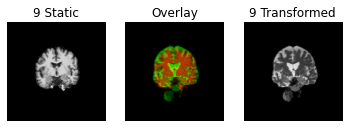

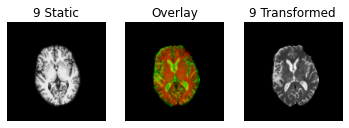

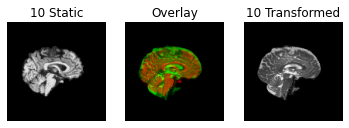

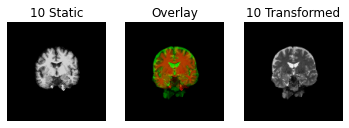

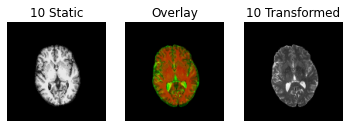

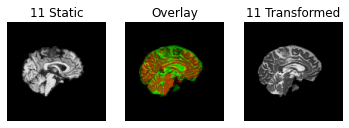

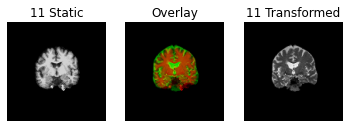

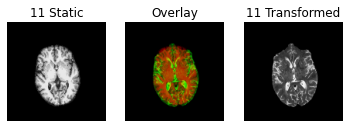

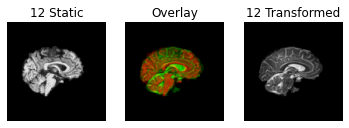

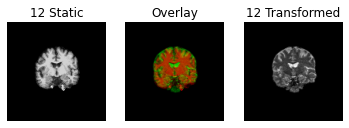

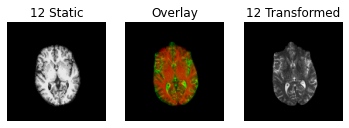

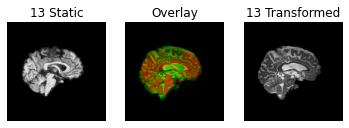

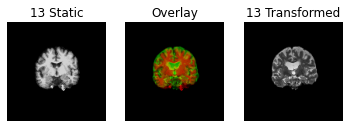

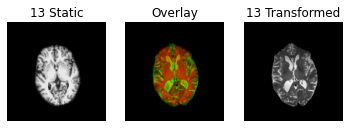

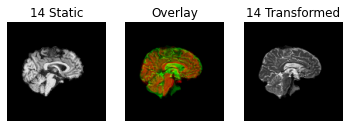

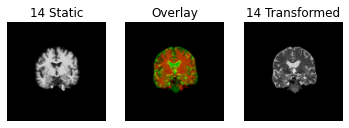

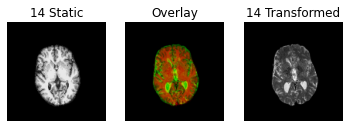

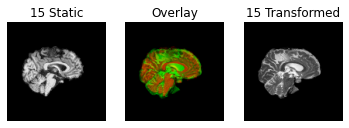

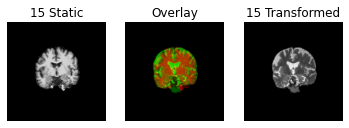

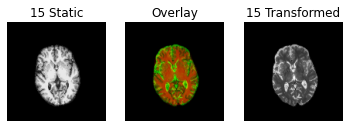

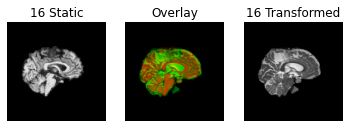

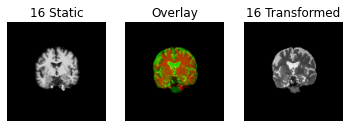

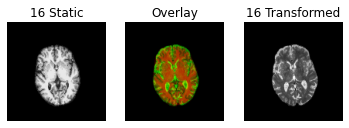

In [ ]:
# def plot_images2(model, moving, static):
#     nb, nd, nh, nw, nc = moving.shape

#     # Repeat the static image along the batch dim.
#     multiples = tf.constant([nb, 1, 1, 1, 1], tf.int32)
#     static = tf.tile(static, multiples)

#     moved, deformation = model({'moving': moving, 'static': static}, training=False)
#     print(deformation.shape, tf.reduce_max(deformation), tf.reduce_min(deformation), tf.reduce_mean(deformation))

#     deformation = deformation.numpy()
#     moved = moved.numpy().squeeze(axis=-1) * 255.0
#     # moved = moved.astype(np.uint8)[:,:,nh//2,...]
#     moving = moving.numpy().squeeze(axis=-1) * 255.0
#     # moving = moving.astype(np.uint8)[:,:,nh//2,...]
#     static = static.numpy().squeeze(axis=-1) * 255.0
#     # static = static.astype(np.uint8)[:,:,nh//2,...]


#     # # Plot images.
#     # fig = plt.figure(figsize=(3 * 1.7, nb * 1.7))
#     # titles_list = ['Static', 'Moved', 'Moving']
#     # images_list = [static, moved, moving]

#     # moved = moving
#     for i in range(nb):
#         # for j in range(3):
#         #     ax = fig.add_subplot(nb, 3, i * 3 + j + 1)
#         #     if i == 0:
#         #         ax.set_title(titles_list[j], fontsize=20)
#         #     ax.set_axis_off()
#         #     ax.imshow(images_list[j][i], cmap='gray')
#         regtools.overlay_slices(static[i], moved[i], None, 0,
#                                 "%d Static"%i, "%d Transformed"%i,
#                                 "%d_0.png" % (i))
#         regtools.overlay_slices(static[i], moved[i], None, 1,
#                                 "%d Static"%i, "%d Transformed"%i,
#                                 "%d_1.png" % (i))
#         regtools.overlay_slices(static[i], moved[i], None, 2,
#                                 "%d Static"%i, "%d Transformed"%i,
#                                 "%d_2.png" % (i))
#         # d = {'static': static[i], 'moved': moved[i], 'moving': moving[i], 'deformation': deformation[i]}
#         # np.save('drive/My Drive/DIPY/t1_t2/results/sample%d_2.npy'%(i), d)

# def main2(args):

#     brain = np.load('/content/drive/My Drive/DIPY/t1_t2/t1_t2_affine_128.npy')
#     static = np.load('/content/drive/My Drive/DIPY/t1_t2/static_128.npy')
#     brain = brain.astype(np.float32)/255.0
#     x_train = brain[:75,...][...,None].copy()
#     # x_train = x_train.astype(np.float32)/255.0
#     x_test = brain[75:,...][...,None].copy()
#     # x_test = x_test.astype(np.float32)/255.0
#     x_sample = x_test.copy()
#     # static = brain[-1,...][None,...,None]
#     static = static[None,...,None]
#     static = static.astype(np.float32)/255.0



#     min_val = min(static.min(), brain.min())
#     max_val = max(static.max(), brain.max())
#     print(min_val, max_val)
#     bin_centers = np.linspace(min_val, max_val, 32)

#     del brain


#     x_train = tf.convert_to_tensor(x_train, dtype='float32')
#     x_test = tf.convert_to_tensor(x_test, dtype='float32')
#     x_sample = tf.convert_to_tensor(x_sample, dtype='float32')
#     static = tf.convert_to_tensor(static, dtype='float32')
#     # print(x_train.shape, x_test.shape, x_sample.shape, static.shape)

#     from_tensor_slices = tf.data.Dataset.from_tensor_slices
#     x_train = from_tensor_slices(x_train).shuffle(10000).batch(args.batch_size)
#     x_test = from_tensor_slices(x_test).shuffle(10000).batch(args.batch_size)

#     S = 128
#     # Create a model instance.
#     model = voxelmorph1(input_shape=(S, S, S))
#     # model.load_weights('drive/My Drive/DIPY/t1_t2/results/checkpoints/59.h5')


#     # Select optimizer and loss function.
#     optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)
#     # criterion = ncc_new
#     criterion = mutualInformation(bin_centers, sigma_ratio=0.5, max_clip=1, crop_background=False, local_mi=True, patch_size=12)

#     # Define the metrics to track training and testing losses.
#     m_train = tf.keras.metrics.Mean(name='loss_train')
#     m_test = tf.keras.metrics.Mean(name='loss_test')

#     # # Train and evaluate the model.
#     # for epoch in range(args.epochs):
#     #     m_train.reset_states()
#     #     m_test.reset_states()
#     #     for i, moving in enumerate(x_train):
#     #         loss_train = train_step(model, moving, static, criterion,
#     #                                 optimizer)
#     #         m_train.update_state(loss_train)

#     #     for i, moving in enumerate(x_test):
#     #         loss_test = test_step(model, moving, static, criterion)
#     #         m_test.update_state(loss_test)

#     #     model.save_weights('drive/My Drive/DIPY/t1_t2/results/checkpoints/%d_2.h5'%epoch)
#     #     print('Epoch: %3d/%d\tTrain Loss: %.6f\tTest Loss: %.6f'
#     #           % (epoch + 1, args.epochs, m_train.result(), m_test.result()))
#     # print('\n')

#     # Show sample results.
#     plot_images2(model, x_sample, static)

#     # Save the trained model.
#     # if args.save_model:
#     #     model.save_weights('/content/drive/My Drive/DIPY/t1_t2/results/voxelmorph1-weights.h5')


# if __name__ == '__main__':

#     class Args():
#         batch_size = 1
#         epochs = 60
#         lr = 0.001
#         # label = 1  # which digit images to train on?
#         # num_samples = 5  # number of sample results to show
#         save_model = True

#     args = Args()
#     main2(args)

In [ ]:
!nvidia-smi

Wed Jul  8 18:08:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |  14579MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------